In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

# Directory with our training non-violation pictures
train_nonviolation_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Benchmark_training/Non_Violation') 

# Directory with our training violation pictures
train_violation_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Benchmark_training/Violation') 

# Directory with our validation non-violation pictures
valid_nonviolation_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Benchmark_validation/Non_violation') 

# Directory with our validation violation pictures
valid_violation_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Benchmark_validation/Violation')

In [ ]:
train_nonviolation_names = [f for f in os.listdir(train_nonviolation_dir)]

print(train_nonviolation_names[:10])

train_violation_names = [f for f in os.listdir(train_violation_dir)]
print(train_violation_names[:10])

validation_nonviolation_names = [f for f in os.listdir(valid_nonviolation_dir)]
print(validation_nonviolation_names[:10])

validation_violation_names = [f for f in os.listdir(valid_violation_dir)]
print(validation_violation_names[:10])

print()

print('total training nonviolation images:', len(os.listdir(train_nonviolation_dir)))
print('total training violation images:', len(os.listdir(train_violation_dir)))
print('total validation nonviolation images:', len(os.listdir(valid_nonviolation_dir)))
print('total validation violation images:', len(os.listdir(valid_violation_dir)))

['_2_2994144.jpg', 'Copy of _6_5523581.jpg', '_0_5482144.jpg', '_4_27430.jpg', '_11_1737337.jpg', '_0_3027222.jpg', '_0_5758239.jpg', '_2_3170619.jpg', '_2_2223697.jpg', 'image19.png']
['Cpic22.jpeg', 'Cpic32.jpeg', 'c_photo13.jpg', 'Cpic37.jpeg', 'Cpic39.jpeg', 'Cpic4.jpg', 'Cpic35.jpeg', 'Cpic30.jpeg', 'c_photo14.jpg', 'Cpic6.jpeg']
['IMG_8562.JPG', 'IMG_8563.JPG', 'IMG_8564.JPG', 'IMG_8561.JPG', 'IMG_8559.JPG', 'IMG_1736.JPG', 'IMG_1737.JPG', 'IMG_1738.JPG', 'IMG_1739.JPG', 'IMG_1741.JPG']
['IMG_8589.JPG', 'IMG_8588.JPG', 'IMG_5656.JPG', 'IMG_5657.JPG', 'IMG_8570.JPG', 'IMG_8565.JPG', 'IMG_5687.JPG', 'IMG_8573.JPG', 'IMG_8567.JPG', 'IMG_8572.JPG']

total training nonviolation images: 567
total training violation images: 722
total validation nonviolation images: 45
total validation violation images: 97


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16

In [ ]:
vgg_model = VGG16(input_shape = (200, 200, 3), 
                                weights='imagenet',
                                include_top = False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from keras.models import Model

x = tf.keras.layers.Flatten()(vgg_model.output)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs = vgg_model.input, outputs = x)

model.compile(loss='binary_crossentropy',
              optimizer = SGD(learning_rate=0.001, momentum=0.9), #SGD(learning_rate=0.001, momentum=0.9)
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory with our training pictures
train_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Benchmark_training') 

# Directory with our validation pictures
valid_dir = os.path.join('gdrive/MyDrive/Data/Data_collection1/Benchmark_validation') 

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,  # source directory for training images
        classes = ['Non_Violation', 'Violation'],
        target_size = (200, 200),  # Images resized to 200x200
        batch_size = 32, #128
        # Use binary labels
        class_mode = 'binary')

# Flow validation images in batches of 16 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        valid_dir,  # source directory for training images
        classes = ['Non_violation', 'Violation'],
        target_size = (200, 200),  # Images resized to 200x200
        batch_size = 16, #32
        # Use binary labels
        class_mode = 'binary',
        shuffle = False)

Found 1289 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
history = model.fit(train_generator,
      # steps_per_epoch=9,  
      epochs = 10,
      verbose = 1,
      validation_data = validation_generator)

In [ ]:
test_dir = os.path.join('gdrive/MyDrive/Data/Data_collection2/other_animals')
test_image_generator = ImageDataGenerator(rescale=1./255)


# Testing on all violation images
test_data_gen = test_image_generator.flow_from_directory(
        directory=test_dir,
        classes=['Violation'], 
        target_size=(200, 200),
        batch_size=1,
        shuffle=False)

pred = model.predict(test_data_gen)
len = pred.shape[0]
probabilities = [1 if x > 0.5 else 0 for x in pred] # 0 means correct
print("Violations:", probabilities) # violations checked
print('Accuracy: ', sum(probabilities)/len)

y_true = [1 for i in range(len)]

print()

# Testing on all non-violation images
test_data_gen = test_image_generator.flow_from_directory(
        directory=test_dir,
        classes=['Non_violation'], 
        target_size=(200, 200),
        batch_size=1,
        # class_mode = 'binary'
        shuffle=False)

pred = model.predict(test_data_gen)
len = pred.shape[0]
probabilities2 = [0 if x > 0.5 else 1 for x in pred] # 1 means correct
print("Non_violations:", probabilities2) # non-violation checked
correct = 0
for i in range(len):
    if probabilities2[i]==0: correct+=1
y_true += [0 for i in range(len)]
print('Accuracy: ', correct/len)

Found 722 images belonging to 1 classes.
Violations: [0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Overall Accuracy: 0.49418153607447635
F1 score: 0.6320541760722347
Recall: 0.775623268698061
Precision: 0.5333333333333333


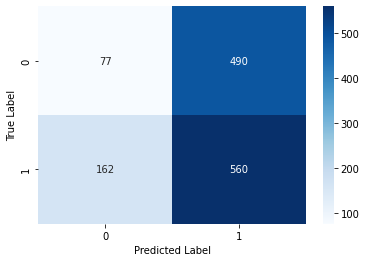

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

probs = probabilities + probabilities2

cm = confusion_matrix(y_true, probs)
map = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues')
map.set(xlabel='Predicted Label', ylabel='True Label')

print ('Overall Accuracy:', accuracy_score(y_true, probs))
print ('F1 score:', f1_score(y_true, probs))
print ('Recall:', recall_score(y_true, probs))
print ('Precision:', precision_score(y_true, probs))